# 1. import libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, confusion_matrix

In [3]:
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 15,5

---
# 2. import dataset

In [4]:
df = pd.read_csv('../0 data/master.csv')
df = df.drop_duplicates()
df.shape

(66034, 6)

---
# 3. Model - 1st iteration

In [5]:
y = df['Y']
x = df.drop(['id','Y'], axis=1)
x = sm.add_constant(x)
log_reg = sm.Logit(y, x).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.228901
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                66034
Model:                          Logit   Df Residuals:                    66029
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Jul 2022   Pseudo R-squ.:                  0.2749
Time:                        18:45:25   Log-Likelihood:                -15115.
converged:                       True   LL-Null:                       -20846.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.042      0.606      0.545      -0.056       0.107
month          0.5001      0.

---
# 4. Model - 2nd iteration

In [6]:
y = df['Y']
x = df.drop(['id','Y'], axis=1)
log_reg = sm.Logit(y, x).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.228904
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                66034
Model:                          Logit   Df Residuals:                    66030
Method:                           MLE   Df Model:                            3
Date:                Sat, 02 Jul 2022   Pseudo R-squ.:                  0.2749
Time:                        18:45:25   Log-Likelihood:                -15115.
converged:                       True   LL-Null:                       -20846.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month          0.4977      0.017     29.373      0.000       0.464       0.531
payment        1.7012      0.

---
# 5. AUROC and Gini

In [7]:
pred_values = log_reg.predict(x)
pred_values = pd.DataFrame(pred_values)[0]
print('AUROC:',np.round(roc_auc_score(y, pred_values), 3))

AUROC: 0.803


In [8]:
auroc = roc_auc_score(y, pred_values)
gini = 2 * auroc - 1
print('Gini:',np.round(gini, 3))

Gini: 0.606


---
# 6. Confusion Matrix

In [9]:
train_dict = {'actuals':y, 'predicted':pred_values}
test_calc = pd.DataFrame(train_dict)

max f:  0.25
max a:  0.55


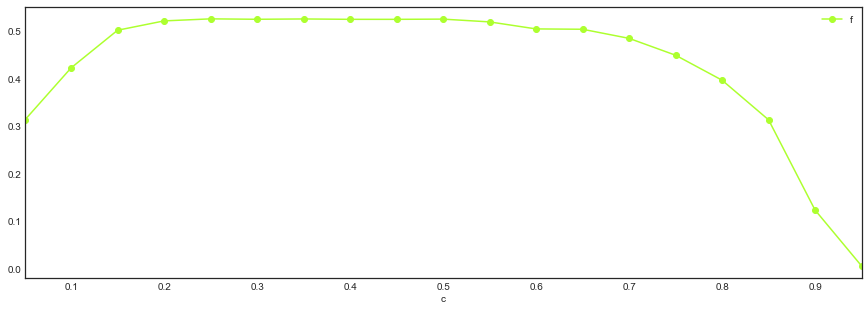

In [10]:
c = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
f = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
a = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

i = 0
for j in c:
    def flag(x):
        if x > j: return 1
        else: return 0
    test_calc['flag'] = test_calc['predicted'].apply(flag)
    df_table = confusion_matrix(test_calc['actuals'],test_calc['flag'])
    p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
    r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
    f[i] = (2 * p * r) / (p + r)
    a[i] = (df_table[0,0] + df_table[1,1]) / df_table.sum()
    i = i+1

df_decision = pd.concat([pd.DataFrame(c),pd.DataFrame(f),pd.DataFrame(a)],axis=1)
df_decision.columns = ['c','f','a']
f_max = df_decision[df_decision['f']==df_decision['f'].max()].head(1)
a_max = df_decision[df_decision['a']==df_decision['a'].max()].head(1)
max_f = float(f_max['c'])
max_a = float(a_max['c'])

df_decision.plot(x='c',y='f',marker="o", color='greenyellow')
print ("max f: ",max_f)
print ("max a: ",max_a)

# 7. Accuracy and F1 Score

In [11]:
def cut_off (x):
    if x > 0.55: return 1
    else: return 0
test_calc['flag'] = test_calc['predicted'].apply(cut_off)
print(confusion_matrix(test_calc['actuals'],test_calc['flag']))

[[59179   531]
 [ 3925  2399]]


In [12]:
c = confusion_matrix(test_calc['actuals'],test_calc['flag'])
print('Accuracy:',np.round((c[0][0] + c[1][1]) / c.sum(),3))

Accuracy: 0.933


In [13]:
p = c[1][1] / (c[1][1] + c[0][1])
r = c[1][1] / (c[1][1] + c[1][0])
print('F1 Score:',np.round((2 * p * r) / (p + r),3))

F1 Score: 0.518
